## Sim Demo

### Imports

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from env.imports import *

In [10]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [11]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 33.8%
RAM Usage: 11.5%
Available RAM: 333.8G
Total RAM: 377.1G
52.4G


In [12]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 0


In [13]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [14]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

In [15]:
# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(dataset='UKBB', parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid,
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping, 
    dataset='UKBB', 
    parcellation='S456'
)

batch_size = 512

# Create global dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

# Create datasets for each subnetwork
unique_networks = np.unique(network_labels)
network_datasets = {}
print("Creating datasets for each subnetwork...")

for network in unique_networks:
    # Create mask for current network
    network_mask = network_labels == network
    
    # Subset data for this network
    X_network = X_valid[network_mask]
    Y_network = Y_valid[network_mask][:, network_mask]
    coords_network = coords_valid[network_mask]
    
    # Create mapping from network indices to true indices
    network_indices = np.where(network_mask)[0]
    network2true_mapping = {i: valid2true_mapping[idx] for i, idx in enumerate(network_indices)}
    
    # Create dataset for this network
    network_datasets[network] = RegionPairDataset(
        X=X_network,
        Y=Y_network, 
        coords=coords_network,
        valid2true_mapping=network2true_mapping, 
        dataset='UKBB', 
        parcellation='S456'
    )
    print(f"Network {network}: {len(network_datasets[network])} region pairs")

# Create dataloaders for each network
batch_size = 512
network_dataloaders = {
    network: DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    ) for network, dataset in network_datasets.items()
}


Loading data...
Creating RegionPairDataset...
Creating datasets for each subnetwork...
Network Cerebellum: 72 region pairs
Network Cont: 2652 region pairs
Network Default: 8190 region pairs
Network DorsAttn: 2070 region pairs
Network Limbic: 650 region pairs
Network SalVentAttn: 2162 region pairs
Network SomMot: 5852 region pairs
Network Subcortical: 2070 region pairs
Network Vis: 3660 region pairs


Load in model trained on best random train-test split

In [51]:
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# Set up base model with the same hyperparameters used for training
smt_base_model = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=20,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.4,
    transformer_dropout=0.4,
    aug_prob=0.0,
    deep_hidden_dims=[512, 256, 128],
    binarize=False
)

# Load saved weights
smt_base_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base_seed9fold3.pt"))
smt_base_model.eval()
smt_base_model.to("cuda")

  warnings.warn(



Number of learnable parameters in SMT model: 4676235


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

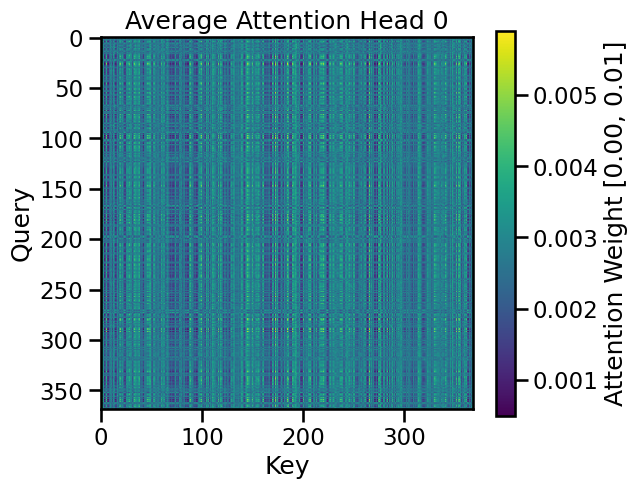

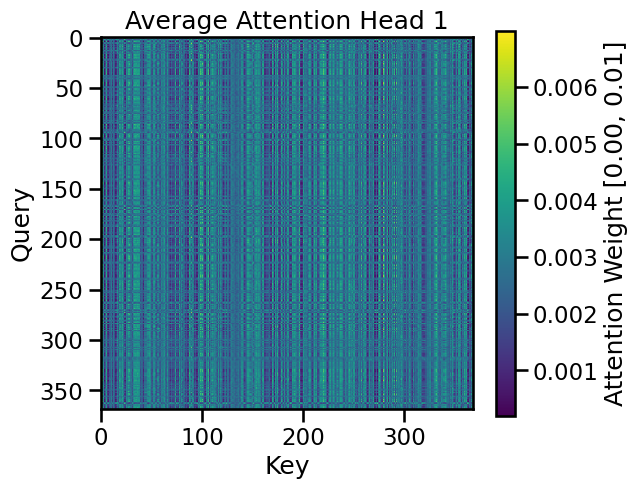

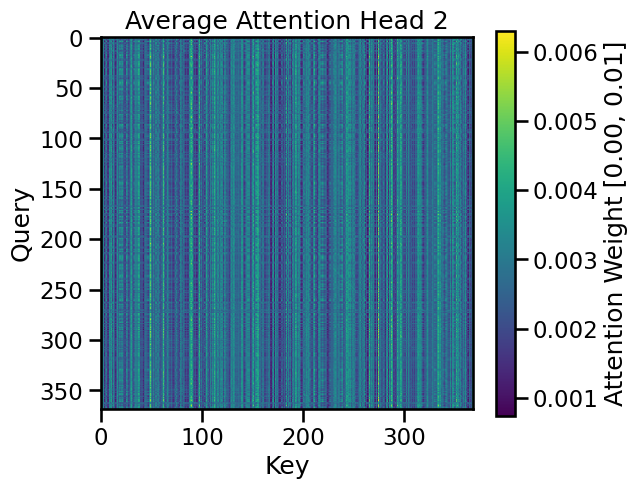

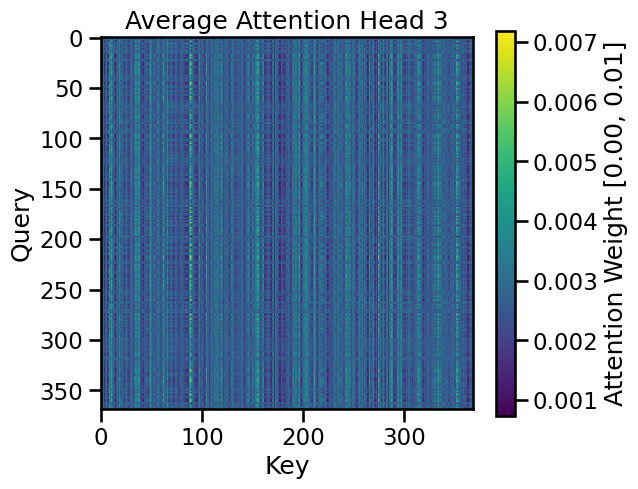

In [ ]:
# UKBB
# predictions_ukbb_base, targets_ukbb_base = smt_base_model.predict(dataloader, 
#                                                                 collect_attn=True, 
#                                                                 save_attn_path='attn_base_SMT_UKBB_seed9fold3.npy')

### Evaluate attention heads

Token dim 20 

In [16]:
def create_gene_tokens(token_chunk_size=20):
    """
    Create gene tokens and chromosome switch points based on token chunk size
    
    Args:
        token_chunk_size (int): Number of genes per token
        
    Returns:
        gene_tokens (list): List of dictionaries containing token info
        chrom_switches (list): List of indices where chromosomes switch
    """
    # Get valid genes from load_transcriptome
    from data.data_load import load_transcriptome

    X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', 
                                      run_PCA=False, omit_subcortical=False, hemisphere='both',
                                      impute_strategy='mirror_interpolate', sort_genes='refgenome', 
                                      return_valid_genes=True, null_model='none', random_seed=42)

    # Get reference genome info for valid genes
    refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')

    valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')
    
    # Create gene groups/tokens
    num_tokens = len(valid_refgenome) // token_chunk_size
    
    gene_tokens = []

    for i in range(num_tokens):
        start_idx = i * token_chunk_size
        end_idx = start_idx + token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:end_idx]
        
        # Get unique chromosome for this token
        chrom = token_genes['chromosome'].iloc[0]
        
        token = {
            'token_id': i,
            'genes': token_genes['gene_id'].tolist(),
            'chromosome': chrom
        }
        gene_tokens.append(token)

    # Handle remaining genes if any
    remaining_genes = len(valid_refgenome) % token_chunk_size
    if remaining_genes > 0:
        start_idx = num_tokens * token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:]
        token = {
            'token_id': num_tokens,
            'genes': token_genes['gene_id'].tolist(), 
            'chromosome': token_genes['chromosome'].iloc[0]
        }
        gene_tokens.append(token)
    # Get chromosome switch points
    chrom_switches = []
    for i in range(1, len(gene_tokens)):
        if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
            chrom_switches.append(i)
    
    # Print token and switch point info
    print(f"Number of tokens: {len(gene_tokens)}")
    print(f"Number of chromosome switch points: {len(chrom_switches)}")
    print("Example token:")
    print(gene_tokens[0])
    # Print chromosome switches to validate
    print("Chromosome switch points:")
    for i in chrom_switches:
        print(f"Switch at token {i}: {gene_tokens[i-1]['chromosome']} -> {gene_tokens[i]['chromosome']}")
    print('\n')
    return gene_tokens, chrom_switches

gene_tokens_20, chrom_switches_20 = create_gene_tokens(token_chunk_size=20)
gene_tokens_60, chrom_switches_60 = create_gene_tokens(token_chunk_size=60)

valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

Plotting functionality for attention head exploration

In [ ]:
# Global font size parameter
FONTSIZE = 24

def plot_all_attention_heads(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    #chrom_switches = chrom_switches[:-1]
    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        if head == 0:  # Only add labels for first plot
            axes[head].set_xlabel("Key", fontsize=FONTSIZE)
            axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add chromosome switch points as ticks
        axes[head].set_xticks(chrom_switches)
        axes[head].set_yticks(chrom_switches)
        axes[head].tick_params(axis='both', which='major', labelsize=FONTSIZE-10)
        axes[head].tick_params(axis='x', rotation=90)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xticks(chrom_switches)
    axes[-1].set_yticks(chrom_switches)
    axes[-1].tick_params(axis='both', which='major', labelsize=FONTSIZE-8)
    axes[-1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

    # Plot colorbar separately
    # fig_cbar = plt.figure(figsize=(2, 6))
    # cbar = plt.colorbar(im, cax=plt.gca(), label=f"[{vmin:.2f}, {vmax:.2f}]")
    # cbar.ax.tick_params(labelsize=FONTSIZE-4)
    # cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    # plt.show()

def plot_average_head(avg_attn, chrom_switches, vectorize=False):
    '''
    Plot average attention weights across all heads
    If vectorize=True, return columnwise mean of average attention
    '''
    
    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    #chrom_switches = chrom_switches[:-1]

    plt.figure(figsize=(8, 7))
    vmin, vmax = avg_head.min(), avg_head.max()
    im = plt.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    plt.title("Average Attention Across All Heads", fontsize=FONTSIZE+2)
    plt.xlabel("Key", fontsize=FONTSIZE)
    plt.ylabel("Query", fontsize=FONTSIZE)
    plt.xticks(chrom_switches, fontsize=FONTSIZE-6, rotation=90)
    plt.yticks(chrom_switches, fontsize=FONTSIZE-6)
    plt.show()

    if vectorize:
        return avg_head.sum(axis=0)
    return avg_head


def plot_all_attention_heads_true_ticks(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    max_idx = attn_weights.shape[1]
    tick_indices = list(range(0, max_idx, 5))
    #chrom_switches = chrom_switches[:-1]

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        axes[head].set_xlabel("Key", fontsize=FONTSIZE)
        axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add indices as ticks with smaller font
        axes[head].set_xticks(tick_indices)
        axes[head].set_yticks(tick_indices)
        axes[head].tick_params(axis='both', which='major', labelsize=6)
        cbar = fig.colorbar(im, ax=axes[head], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
        cbar.ax.tick_params(labelsize=FONTSIZE-8)
        cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xlabel("Key", fontsize=FONTSIZE)
    axes[-1].set_ylabel("Query", fontsize=FONTSIZE)
    axes[-1].set_xticks(tick_indices)
    axes[-1].set_yticks(tick_indices)
    axes[-1].tick_params(axis='both', which='major', labelsize=6)
    cbar = fig.colorbar(im, ax=axes[-1], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    plt.tight_layout()
    plt.show()

def create_gene_attention_df(gene_tokens, summed_attention_vec):
    """
    Create a dataframe mapping genes to their attention scores.
    
    Args:
        gene_tokens (list): List of dictionaries containing gene information per token
        summed_attention_vec (np.array): Vector of attention scores for each token
        
    Returns:
        pd.DataFrame: DataFrame with columns 'Gene' and 'Attention_Score'
    """
    # Add attention scores to gene tokens
    for i, token in enumerate(gene_tokens):
        token['attention_score'] = summed_attention_vec[i]
        
    # Create lists to store gene IDs and their attention scores
    genes = []
    attention_scores = []
    
    # Iterate through tokens and extract gene-attention pairs
    for token in gene_tokens:
        # Each gene in the token gets the same attention score
        for gene in token['genes']:
            genes.append(gene)
            attention_scores.append(token['attention_score'])
            
    # Create and return dataframe
    gene_attention_df = pd.DataFrame({
        'Gene': genes,
        'Attention_Score': attention_scores
    })
    
    return gene_attention_df

UKBB Model Attention:


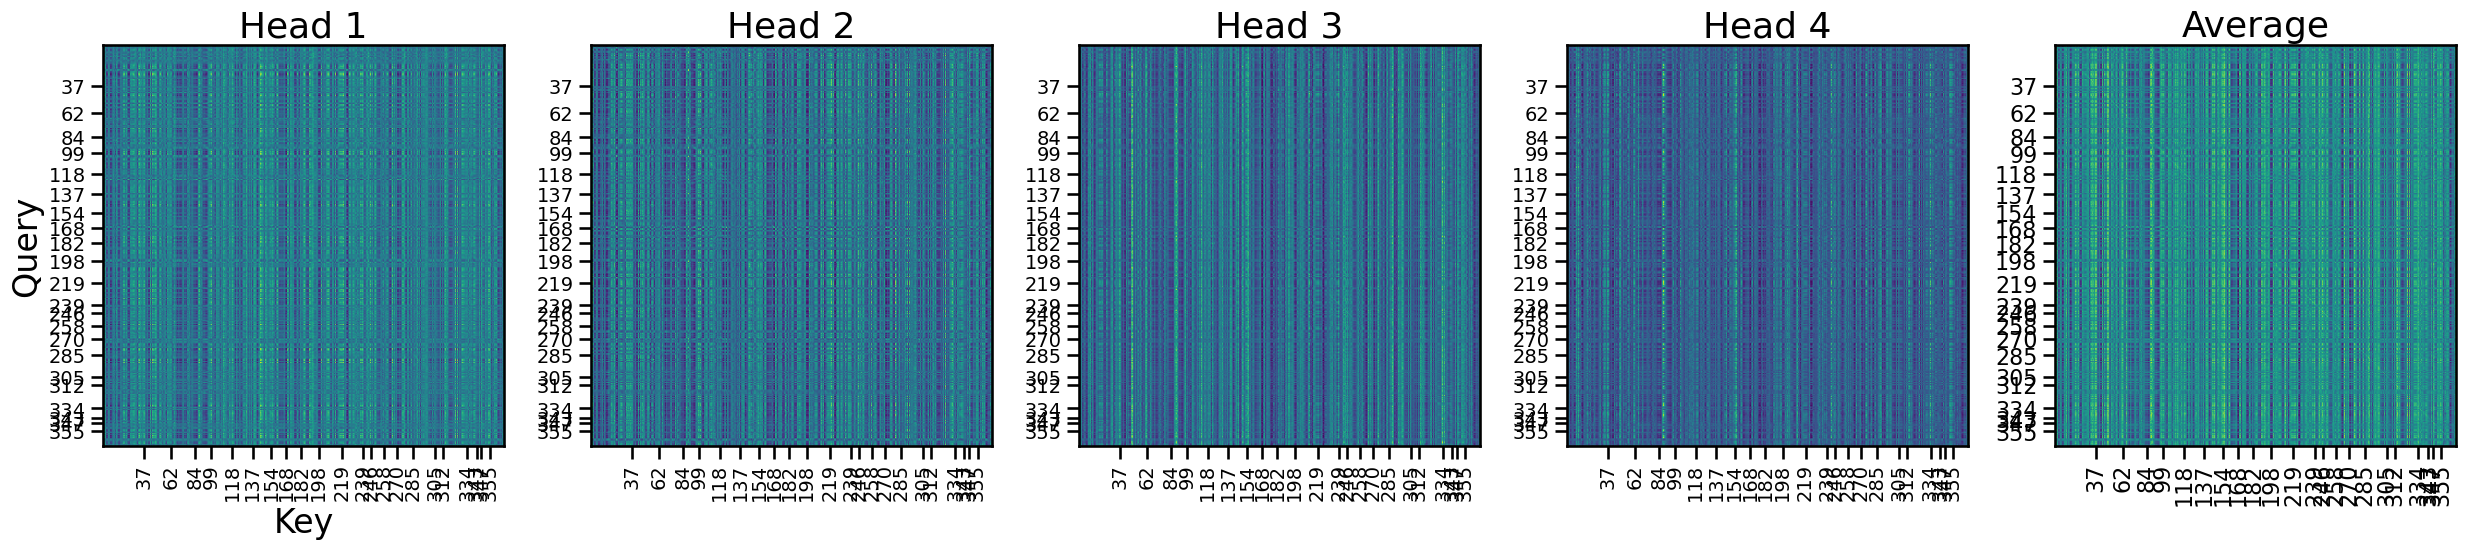

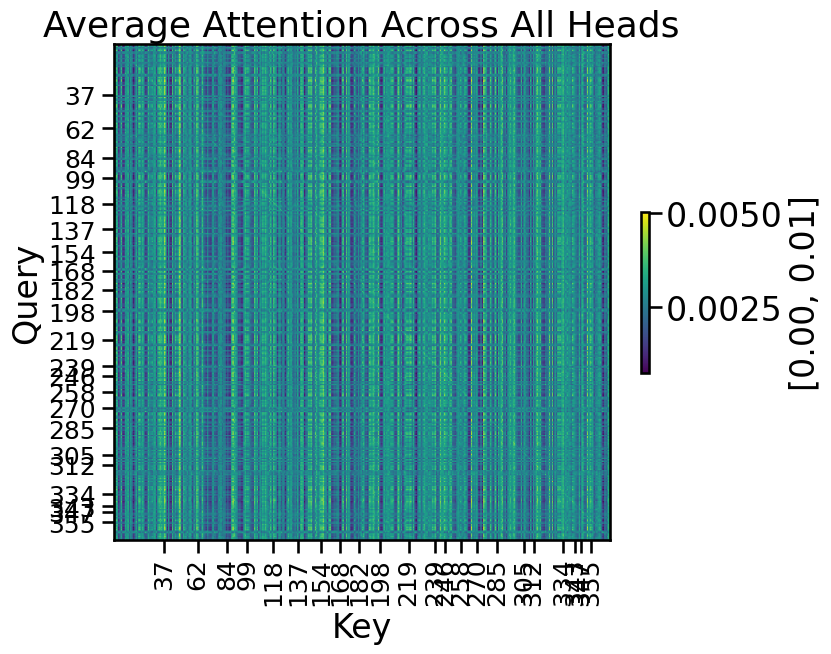

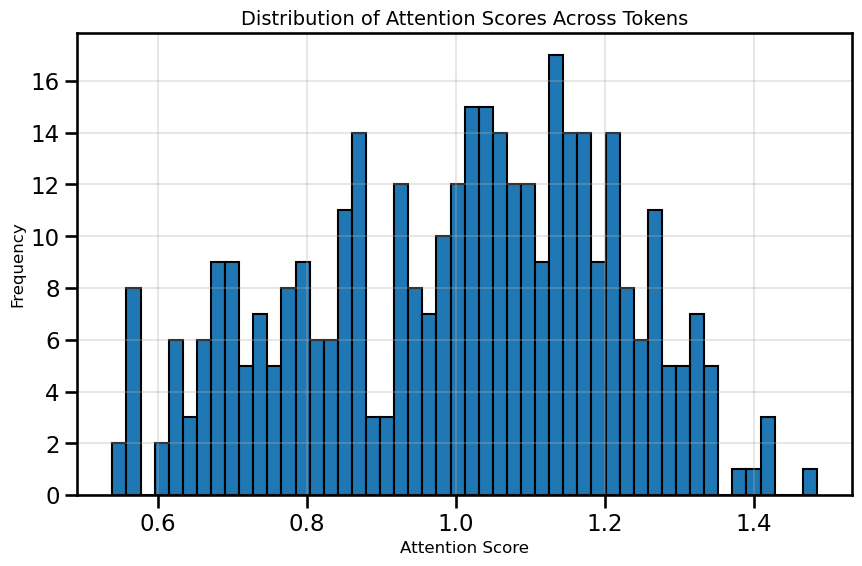

In [22]:
# Load if already computed
avg_base_smt_20dim_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_UKBB_seed9fold3.npy')

# Plot attention weights for UKBB model
print("UKBB Model Attention:")
plot_all_attention_heads(avg_base_smt_20dim_attn_ukbb, chrom_switches_20)

summed_attention_20_vec = plot_average_head(avg_base_smt_20dim_attn_ukbb, chrom_switches_20, vectorize=True)

plt.figure(figsize=(10,6))
plt.hist(summed_attention_20_vec, bins=50, edgecolor='black')
plt.xlabel('Attention Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Attention Scores Across Tokens', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


In [24]:
gene_attention_20_df = create_gene_attention_df(gene_tokens_20, summed_attention_20_vec)
print("Created gene-attention dataframe with shape:", gene_attention_20_df.shape)
gene_attention_20_df.head()

gene_attention_20_df.to_csv('gene_attention_20_dim.csv', index=False)

Created gene-attention dataframe with shape: (7380, 2)


GSEA

In [33]:
gene_attention_20_df = gene_attention_20_df.sort_values('Attention_Score', ascending=False)
# write without header
gene_attention_20_df[['Gene','Attention_Score']].to_csv(f'gene_attention_20_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)
pre_res = gp.prerank(
    rnk='gene_attention.rnk',
    gene_sets='KEGG_2021_Human',
    min_size=15,              # Minimum gene set size
    max_size=60,             # Maximum gene set size
    permutation_num=1000,     # Number of permutations
    weight=1,                 # Weight for ranking
    ascending=False,          # Sort descending
    threads=4,                # Number of threads
    figsize=[6.5,6],         # Figure size
    outdir=None,             # Don't write files
    format='pdf',            # Figure format
    graph_num=20,            # Plot top 20 enriched sets
    no_plot=False,           # Generate plots
    seed=42,                 # Random seed
    verbose=True             # Print progress
)

pre_res.res2d.head(20)

2025-07-17 11:45:29,452 [WARNING] Duplicated values found in preranked stats: 95.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-17 11:45:29,452 [INFO] Parsing data files for GSEA.............................
2025-07-17 11:45:29,453 [INFO] Enrichr library gene sets already downloaded in: /home/asr655/.cache/gseapy, use local file
2025-07-17 11:45:29,466 [INFO] 0151 gene_sets have been filtered out when max_size=60 and min_size=15
2025-07-17 11:45:29,466 [INFO] 0169 gene_sets used for further statistical testing.....


2025-07-17 11:45:29,467 [INFO] Start to run GSEA...Might take a while..................
2025-07-17 11:45:31,593 [INFO] Congratulations. GSEApy runs successfully................



Name                                    Term        ES       NES  \
0   prerank         Staphylococcus aureus infection   0.40631  2.106204   
1   prerank       Ribosome biogenesis in eukaryotes  0.445868  1.968165   
2   prerank                Type I diabetes mellitus  0.450423  1.858016   
3   prerank                  Fanconi anemia pathway -0.344805 -1.795223   
4   prerank     Antigen processing and presentation  0.339674  1.769781   
5   prerank     Aldosterone synthesis and secretion  0.265699  1.759684   
6   prerank              Hematopoietic cell lineage  0.352362  1.737606   
7   prerank         Arginine and proline metabolism  0.326971  1.694775   
8   prerank              Non-small cell lung cancer  0.295645  1.677194   
9   prerank                         Renin secretion  0.293539  1.651259   
10  prerank            Systemic lupus erythematosus  0.341203  1.646278   
11  prerank      Cysteine and methionine metabolism  0.311355  1.602032   
12  prerank               Thyroid hormone synthesis   0.27351  1.573165   
13  prerank              Nucleotide excision repair  -0.31214 -1.568692   
14  prerank        Cortisol synthesis and secretion  0.287815  1.515851   
15  prerank                           Leishmaniasis   0.27007  1.502041   
16  prerank                           Legionellosis  0.311535  1.483292   
17  prerank  Various types of N-glycan biosynthesis  0.342358   1.45729   
18  prerank               Th17 cell differentiation  0.254162  1.449156   
19  prerank              JAK-STAT signaling pathway -0.163537 -1.448172   

   NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0   0.002336  0.138885      0.115  19/27  35.72%   
1   0.003817  0.201333      0.293  10/18  21.33%   
2   0.005236  0.326396      0.546  12/15  40.38%   
3   0.018779  0.287513      0.237  15/17  48.96%   
4   0.008255  0.449627      0.744  19/30  35.72%   
5   0.010695  0.382083      0.769  38/58  47.20%   
6   0.014888   0.36986      0.813  18/25  42.82%   
7   0.016509  0.416226       0.88  24/29  56.27%   
8   0.023464  0.409286      0.918  24/38  43.31%   
9    0.03171  0.428867      0.948  26/35  51.64%   
10  0.030048  0.400868      0.955  14/23  36.30%   
11  0.034606  0.476787      0.977  23/28  56.64%   
12   0.04328  0.517738      0.986  19/37  32.74%   
13   0.03913  0.470475      0.558  15/16  59.32%   
14  0.050119  0.660299      0.994  12/30  18.51%   
15  0.055872  0.661809      0.998  19/35  35.72%   
16  0.061958  0.680969      0.998  12/22  32.15%   
17  0.084975  0.732206        1.0  10/18  29.01%   
18  0.078767    0.7167        1.0  21/40  35.72%   
19  0.055556  0.559946      0.759  28/44  38.67%   

                                           Lead_genes  
0   C3;KRT31;KRT14;KRT19;KRT17;FCGR3A;C1S;C1R;ITGB...  
1   RPP25;RAN;IMP4;POP7;HEATR1;NHP2;TCOF1;BMS1;EMG...  
2   IL1B;ICA1;HLA-DMB;HLA-DMA;HLA-DPB1;HLA-DPA1;HL...  
3   FANCL;ERCC4;RMI2;RPA2;PMS2;TOP3A;HES1;REV1;RAD...  
4   CTSL;CANX;CD74;RFX5;KLRC3;KLRC2;PDIA3;B2M;CD8B...  
5   CAMK1;ITPR1;ATF4;CACNA1I;ATP2B3;GNAQ;LIPE;CACN...  
6   IL1B;CSF1R;CD24;CD8B;IL4R;CD33;ITGAM;IL3RA;CD5...  
7   OAT;SAT2;GOT2;ALDH1B1;ALDH9A1;P4HA1;GOT1;CKMT1...  
8   PLCG2;MAPK1;HGF;MAP2K2;SOS2;PIK3CD;MET;RET;RAS...  
9   PPP3CC;ITPR1;GNAQ;AQP1;ADCYAP1R1;EDN1;PPP3R1;A...  
10  ACTN4;C3;SNRPB;FCGR3A;C1S;C1R;HLA-DMB;HLA-DMA;...  
11  BHMT2;PSAT1;AHCYL1;GOT2;DNMT3A;LDHB;BCAT1;GCLM...  
12  PAX8;ITPR1;ATF4;ALB;GNAQ;CANX;ASGR1;ASGR2;ATP1...  
13  ERCC4;RPA2;RFC1;ERCC2;ERCC8;POLE4;ERCC6;RFC3;R...  
14  ITPR1;ATF4;CACNA1I;GNAQ;CACNA1G;CREB3L3;LDLR;A...  
15  IL1B;C3;MAPK1;ITGB1;FCGR3A;ITGB2;PRKCB;ITGAM;M...  
16  IL1B;C3;CLK4;CYCS;CXCL3;CXCL2;ITGB2;EEF1G;HSPA...  
17  HEXB;TUSC3;MGAT1;MGAT4B;ST3GAL3;B4GALT2;ALG2;M...  
18  IL1B;PPP3CC;IL17D;MAPK1;PPP3R1;TGFBR1;PPP3CB;M...  
19  JAK2;STAM2;SOCS1;BCL2;PIAS2;IL15;CCND1;SOCS5;P...

  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))



  ax.figure.tight_layout()



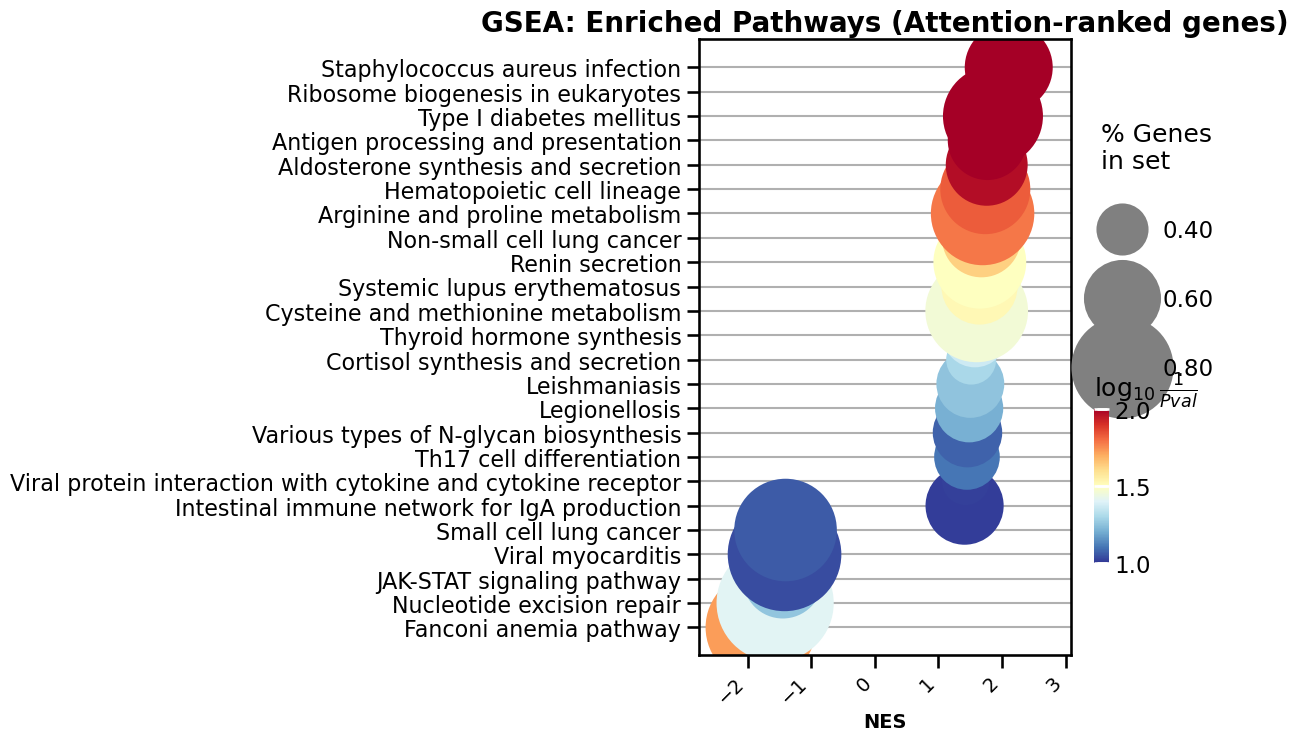

In [34]:
from gseapy.plot import dotplot

ax = dotplot(
    df=pre_res.res2d,
    title='GSEA: Enriched Pathways (Attention‑ranked genes)',
    column='NOM p-val',  # Default column name for FDR values
    x='NES',                   # x-axis = normalized enrichment score 
    y='Term',                  # y-axis = pathway names
    cutoff=0.1,              # Only show terms with adj p-value < 0.05
    top_term=15,              # Show top 15 enriched terms
    size=10,                  # Base dot size
    figsize=(6,8),
    cmap='RdYlBu_r',         # Red-Yellow-Blue colormap (reversed)
    xticklabels_rot=45,      # Rotate x-axis labels 45 degrees
    marker='o'               # Use circular markers
)
ax.figure.tight_layout()
# ax.figure.savefig('gsea_dotplot.pdf', dpi=300)

Token dim 60 

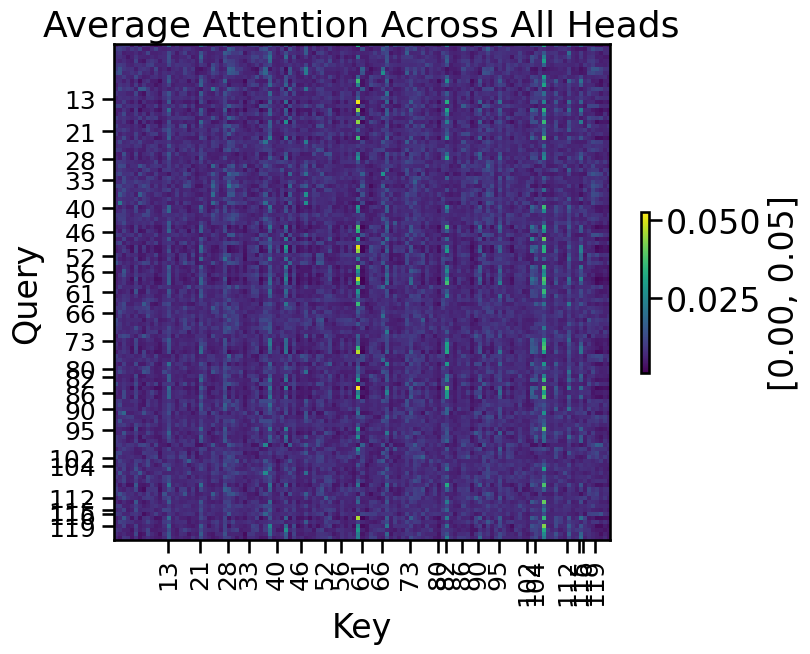

Created gene-attention dataframe with shape: (7380, 2)


Gene  Attention_Score
0  LOC729737         0.994391
1  LINC01128         0.994391
2     SAMD11         0.994391
3      PERM1         0.994391
4       HES4         0.994391

In [35]:
avg_base_smt_60dim_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training.npy')
summed_attention_60_vec = plot_average_head(avg_base_smt_60dim_attn_ukbb, chrom_switches_60, vectorize=True)

# Usage
gene_attention_60_df = create_gene_attention_df(gene_tokens_60, summed_attention_60_vec)
print("Created gene-attention dataframe with shape:", gene_attention_60_df.shape)
gene_attention_60_df.head()

In [40]:
import gseapy as gp

gene_attention_60_df = gene_attention_60_df.sort_values('Attention_Score', ascending=False)

# write without header
gene_attention_60_df[['Gene','Attention_Score']].to_csv(f'gene_attention_60_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)

pre_res = gp.prerank(
    rnk='gene_attention.rnk',
    gene_sets='KEGG_2021_Human',
    min_size=15,              # Minimum gene set size
    max_size=7380,             # Maximum gene set size
    permutation_num=1000,     # Number of permutations
    weight=1,                 # Weight for ranking
    ascending=False,          # Sort descending
    threads=4,                # Number of threads
    figsize=[6.5,6],         # Figure size
    outdir=None,             # Don't write files
    format='pdf',            # Figure format
    graph_num=20,            # Plot top 20 enriched sets
    no_plot=False,           # Generate plots
    seed=42,                 # Random seed
    verbose=True             # Print progress
)

pre_res.res2d.head(20)

2025-07-17 11:48:10,708 [WARNING] Duplicated values found in preranked stats: 95.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-17 11:48:10,709 [INFO] Parsing data files for GSEA.............................
2025-07-17 11:48:10,709 [INFO] Enrichr library gene sets already downloaded in: /home/asr655/.cache/gseapy, use local file
2025-07-17 11:48:10,723 [INFO] 0068 gene_sets have been filtered out when max_size=7380 and min_size=15
2025-07-17 11:48:10,723 [INFO] 0252 gene_sets used for further statistical testing.....
2025-07-17 11:48:10,724 [INFO] Start to run GSEA...Might take a while..................
2025-07-17 11:48:16,546 [INFO] Congratulations. GSEApy runs successfully................



Name                                     Term        ES       NES  \
0   prerank          Staphylococcus aureus infection   0.40631  2.106204   
1   prerank        Ribosome biogenesis in eukaryotes  0.445868  1.968165   
2   prerank                 Type I diabetes mellitus  0.450423  1.858016   
3   prerank  Neuroactive ligand-receptor interaction  0.225572  1.810759   
4   prerank                   Fanconi anemia pathway -0.344805 -1.795223   
5   prerank      Antigen processing and presentation  0.339674  1.769781   
6   prerank      Aldosterone synthesis and secretion  0.265699  1.759684   
7   prerank               Hematopoietic cell lineage  0.352362  1.737606   
8   prerank          Arginine and proline metabolism  0.326971  1.694775   
9   prerank                   cAMP signaling pathway  0.214199  1.678165   
10  prerank               Non-small cell lung cancer  0.295645  1.677194   
11  prerank                          Renin secretion  0.293539  1.651259   
12  prerank             Systemic lupus erythematosus  0.341203  1.646278   
13  prerank       Cysteine and methionine metabolism  0.311355  1.602032   
14  prerank                Thyroid hormone synthesis   0.27351  1.573165   
15  prerank               Nucleotide excision repair  -0.31214 -1.568692   
16  prerank               cGMP-PKG signaling pathway  0.212374  1.556736   
17  prerank         Cortisol synthesis and secretion  0.287815  1.515851   
18  prerank                            Leishmaniasis   0.27007  1.502041   
19  prerank                Relaxin signaling pathway  0.223664  1.485783   

   NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
0   0.002336  0.166179      0.134   19/27  35.72%   
1   0.003817  0.251258      0.338   10/18  21.33%   
2   0.005236  0.398365      0.592   12/15  40.38%   
3        0.0  0.432363       0.71  73/132  40.76%   
4   0.018779  0.318101      0.248   15/17  48.96%   
5   0.008255   0.46331      0.789   19/30  35.72%   
6   0.010695  0.414286      0.811   38/58  47.20%   
7   0.014888  0.418503       0.85   18/25  42.82%   
8   0.016509  0.488585      0.913   24/29  56.27%   
9   0.013252   0.48759      0.947  66/117  44.36%   
10  0.023464  0.441717      0.948   24/38  43.31%   
11   0.03171  0.474835      0.966   26/35  51.64%   
12  0.030048  0.450938      0.969   14/23  36.30%   
13  0.034606  0.551199      0.986   23/28  56.64%   
14   0.04328  0.612047      0.993   19/37  32.74%   
15   0.03913  0.527213      0.579   15/16  59.32%   
16  0.032956     0.634      0.995   54/89  47.43%   
17  0.050119  0.751847        1.0   12/30  18.51%   
18  0.055872  0.765569        1.0   19/35  35.72%   
19  0.060897  0.792638        1.0   32/64  35.15%   

                                           Lead_genes  
0   C3;KRT31;KRT14;KRT19;KRT17;FCGR3A;C1S;C1R;ITGB...  
1   RPP25;RAN;IMP4;POP7;HEATR1;NHP2;TCOF1;BMS1;EMG...  
2   IL1B;ICA1;HLA-DMB;HLA-DMA;HLA-DPB1;HLA-DPA1;HL...  
3   NTSR2;GRM7;OXTR;NPFFR2;NMU;HTR2A;LPAR6;GABRA3;...  
4   FANCL;ERCC4;RMI2;RPA2;PMS2;TOP3A;HES1;REV1;RAD...  
5   CTSL;CANX;CD74;RFX5;KLRC3;KLRC2;PDIA3;B2M;CD8B...  
6   CAMK1;ITPR1;ATF4;CACNA1I;ATP2B3;GNAQ;LIPE;CACN...  
7   IL1B;CSF1R;CD24;CD8B;IL4R;CD33;ITGAM;IL3RA;CD5...  
8   OAT;SAT2;GOT2;ALDH1B1;ALDH9A1;P4HA1;GOT1;CKMT1...  
9   ROCK2;OXTR;PAK1;ATP2B3;VAV1;LIPE;RYR2;ADCYAP1R...  
10  PLCG2;MAPK1;HGF;MAP2K2;SOS2;PIK3CD;MET;RET;RAS...  
11  PPP3CC;ITPR1;GNAQ;AQP1;ADCYAP1R1;EDN1;PPP3R1;A...  
12  ACTN4;C3;SNRPB;FCGR3A;C1S;C1R;HLA-DMB;HLA-DMA;...  
13  BHMT2;PSAT1;AHCYL1;GOT2;DNMT3A;LDHB;BCAT1;GCLM...  
14  PAX8;ITPR1;ATF4;ALB;GNAQ;CANX;ASGR1;ASGR2;ATP1...  
15  ERCC4;RPA2;RFC1;ERCC2;ERCC8;POLE4;ERCC6;RFC3;R...  
16  PPP3CC;ROCK2;ITPR1;ATF4;ATP2B3;INSR;GNAQ;ATP1B...  
17  ITPR1;ATF4;CACNA1I;GNAQ;CACNA1G;CREB3L3;LDLR;A...  
18  IL1B;C3;MAPK1;ITGB1;FCGR3A;ITGB2;PRKCB;ITGAM;M...  
19  ATF4;GNB2;MAP2K4;GNG4;MAPK1;EDN1;MAP2K2;CREB3L...

  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))



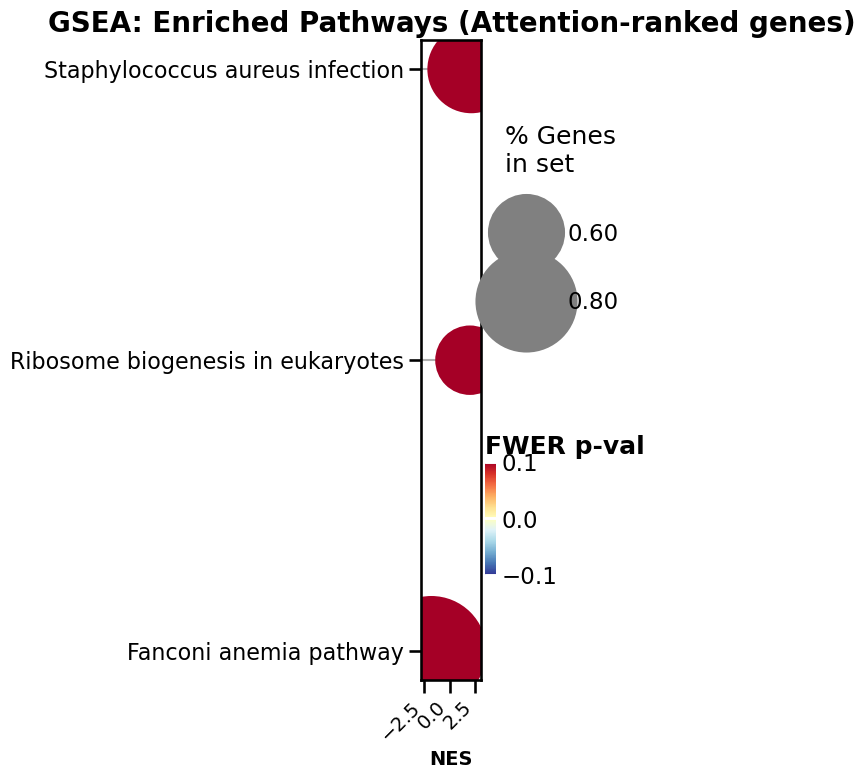

In [32]:
ax = dotplot(
    df=pre_res.res2d,
    title='GSEA: Enriched Pathways (Attention‑ranked genes)',
    column='FWER p-val',  # Default column name for FDR values
    x='NES',                   # x-axis = normalized enrichment score 
    y='Term',                  # y-axis = pathway names
    cutoff=0.5,              # Only show terms with adj p-value < 0.05
    top_term=15,              # Show top 15 enriched terms
    size=10,                  # Base dot size
    figsize=(6,8),
    cmap='RdYlBu_r',         # Red-Yellow-Blue colormap (reversed)
    xticklabels_rot=45,      # Rotate x-axis labels 45 degrees
    marker='o'               # Use circular markers
)
ax.figure.tight_layout()
# ax.figure.savefig('gsea_dotplot.pdf', dpi=300)

Token list grabber

In [46]:
gene_attention_60_df

Gene  Attention_Score
6416   PLEKHF1         2.353067
6417  C19orf12         2.353067
6418     CCNE1         2.353067
6419      URI1         2.353067
6396      COMP         2.353067
...        ...              ...
683       COA6         0.673643
664       GUK1         0.673643
665       GJC2         0.673643
666      OBSCN         0.673643
667     TRIM17         0.673643

[7380 rows x 2 columns]

In [57]:
print(" ".join(gene_attention_60_df.head(3*60)['Gene'].tolist()))

PLEKHF1 C19orf12 CCNE1 URI1 COMP CERS1 HOMER3 SUGP2 RAB8A FAM32A AP1M1 KLF2 HAUS8 OCEL1 BABAM1 ABHD8 ZNF714 ZNF493 ZNF429 IPO5P1 GATAD2A YJEFN3 PBX4 GMIP IQCN LSM4 ISYNA1 ELL ZNF681 ZNF254 UQCRFS1 POP4 KCNN1 MAST3 IFI30 MPV17L2 RFXANK NR2C2AP NCAN HAPLN4 KXD1 UBA52 CRLF1 TMEM59L ZNF333 AKAP8 WIZ RASAL3 TMEM38A NWD1 SIN3B CPAMD8 NANOS3 C19orf57 DDX39A DNAJB1 MRPL34 DDA1 UNC13A CCDC124 TUBB4B IDI1 OLFM1 NACC2 GPSM1 CARD9 SLC2A6 ADAMTSL2 FAM163B SARDH LCN15 TMEM141 PMPCA SEC16A EGFL7 SNHG7 TUBB8 ZMYND11 IDI2-AS1 PHPT1 AKR1C4 CALML3 ASB13 ANKRD16 NPDC1 SAPCD2 MAN1B1-AS1 DPP7 LOC105376360 KLF6 AKR1C1 AKR1C3 EXD3 NSMF PNPLA7 EHMT1 WDR37 ADARB2-AS1 PFKP PITRM1 PFKFB3 PRKCQ-AS1 SFMBT2 ITIH5 TAF3 CELF2 USP6NL ECHDC3 VAV2 RXRA COL5A1 NRARP FBXW5 PPP1R26 C9orf116 SOHLH1 KCNT1 TMEM203 RNF208 TMEM250 HECTD1 ARHGAP5-AS1 AKAP6 NPAS3 RABGGTA STXBP6 NOVA1 FOXG1 PPP2R3C PSMA6 NFKBIA INSM2 LINC01551 PRKD1 COCH AP4S1 EGLN3 SPTSSA CFL2 BAZ1A ARHGEF40 ZNF219 HNRNPC RAB2B PNP RNASE6 METTL17 NDRG2 DCAF11 PSME

In [52]:
gene_attention_20_df

Gene  Attention_Score
965    SLC20A1         1.485096
967       PAX8         1.485096
978       RALB         1.485096
969    SLC35F5         1.485096
968   PAX8-AS1         1.485096
...        ...              ...
3363     CD274         0.538540
3373   ZDHHC21         0.538540
3379  ADAMTSL1         0.538540
3364     ERMP1         0.538540
3372      NFIB         0.538540

[7380 rows x 2 columns]

In [56]:
print(" ".join(gene_attention_20_df.head(10*20)['Gene'].tolist()))

SLC20A1 PAX8 RALB SLC35F5 PAX8-AS1 TMEM87B DPP10 PTPN4 ZC3H8 POLR1B TTL MARCO IL1B TMEM185B INHBB DPP10-AS1 C1QL2 FBLN7 EPB41L5 DBI CLK3 NEIL1 NRG4 ARID3B ISLR FBXO22 ULK3 SEMA7A DNM1P35 SCAMP5 UBL7-AS1 UBL7 CSPG4 MPI COX5A RPP25 TMEM266 SCAPER EDC3 CPLX3 EEF2K RRN3P3 UQCRC2 VWA3A CRYM SYT17 C16orf45 ITPRIPL2 IGSF6 METTL9 NPIPA8 XYLT1 PKD1P6-NPIPP1 IQCK ABCC6 GDE1 MARF1 TMEM159 LYRM1 ACSM5 ADAM28 RHOBTB2 PEBP4 NEFM SORBS3 HR PPP3CC BIN3 POLR3D NKX3-1 ENTPD4 SLC39A14 PHYHIP DMTN LGI3 FGF17 TNFRSF10B EGR3 SLC25A37 NUDT18 LPIN1 VSNL1 ITGB1BP1 HPCAL1 CYS1 NTSR2 FAM84A YWHAQ DDX1 FLJ33534 LAPTM4A NBAS TRIB2 PAN2 WDR35 KCNF1 KCNS3 SMC6 ROCK2 KLHL29 GRM7 LMCD1 ARPC4 CAMK1 SRGAP3 OXTR SUMF1 ITPR1 RPUSD3 CHL1 PDCD1 OGG1 CPNE9 EDEM1 CIDEC LOC285097 CNTN6 CNTN4 BHLHE40 LRRN1 KCNJ4 SYNGR1 PDXP LGALS1 DNAL4 CBX7 JOSD1 CBX6 MIEF1 ATF4 MICALL1 C22orf23 NPTXR RPL3 TMEM184B BAIAP2L2 SLC16A8 PICK1 RPS19BP1 CACNA1I YTHDC1 DBP GRSF1 MOB1B REST SPINK2 ADGRL3 NPFFR2 ALB EPHA5 AASDH CENPC SRD5A3 SLC4A4 PDGFR

Manual grab

In [75]:
print(" ".join(gene_tokens_60[54]['genes']))

RUNX1T1 PDP1 GEM RAD54B FSBP INTS8 MTERF3 SDC2 TSPYL5 MTDH LAPTM4B MATN2 RPL30 ERICH5 RIDA NIPAL2 KCNS2 RGS22 POLR2K PABPC1 YWHAZ ZNF706 NCALD RRM2B UBR5 KLF10 GASAL1 AZIN1 AZIN1-AS1 ATP6V1C1 FZD6 SLC25A32 RIMS2 LRP12 ZFPM2 OXR1 ANGPT1 RSPO2 EMC2 TMEM74 NUDCD1 ENY2 SYBU KCNV1 CSMD3 TRPS1 AARD EXT1 SAMD12 MAL2 TAF2 DSCC1 DEPTOR MRPL13 MTBP SNTB1 ZHX2 DERL1 FBXO32 TMEM65


In [71]:
print(" ".join(gene_tokens_60[28]['genes']))

NSD2 NELFA NAT8L HAUS3 MXD4 ZFYVE28 ADD1 NOP14 MSANTD1 RGS12 DOK7 LRPAP1 ADRA2C FAM86EP NSG1 STX18 MSX1 CYTL1 CRMP1 JAKMIP1 WFS1 MRFAP1 LINC02482 TBC1D14 CCDC96 TADA2B SORCS2 ABLIM2 ACOX3 DEFB131A WDR1 HS3ST1 CPEB2 CD38 TAPT1 LDB2 QDPR DCAF16 SLIT2 ADGRA3 PPARGC1A LGI2 ANAPC4 SEL1L3 TBC1D19 STIM2 PCDH7 ARAP2 NWD2 RELL1 TBC1D1 PTTG2 FAM114A1 KLHL5 WDR19 RFC1 RPL9 LIAS SMIM14 UBE2K


In [68]:
print(" ".join(gene_tokens_60[60]['genes']))

SLC2A6 ADAMTSL2 FAM163B SARDH VAV2 RXRA COL5A1 OLFM1 PPP1R26 C9orf116 SOHLH1 KCNT1 NACC2 TMEM250 GPSM1 CARD9 PMPCA SEC16A EGFL7 SNHG7 LCN15 TMEM141 PHPT1 FBXW5 NPDC1 SAPCD2 MAN1B1-AS1 DPP7 TMEM203 RNF208 TUBB4B NRARP EXD3 NSMF PNPLA7 EHMT1 TUBB8 ZMYND11 IDI2-AS1 IDI1 WDR37 ADARB2-AS1 PFKP PITRM1 LOC105376360 KLF6 AKR1C1 AKR1C3 AKR1C4 CALML3 ASB13 ANKRD16 PFKFB3 PRKCQ-AS1 SFMBT2 ITIH5 TAF3 CELF2 USP6NL ECHDC3


In [69]:
print(" ".join(gene_tokens_60[82]['genes']))

PNP RNASE6 METTL17 NDRG2 ARHGEF40 ZNF219 HNRNPC RAB2B TOX4 SALL2 DAD1 ABHD4 OXA1L SLC7A7 PRMT5 HAUS4 PSMB5 C14orf119 SLC7A8 HOMEZ PPP1R3E BCL2L2 MYH7 THTPA ZFHX2 AP1G2 JPH4 DHRS2 DHRS4 CARMIL3 CPNE6 PCK2 DCAF11 PSME1 PSME2 RNF31 CHMP4A NEDD8 GMPR2 TGM1 RABGGTA STXBP6 NOVA1 FOXG1 LINC01551 PRKD1 COCH AP4S1 HECTD1 ARHGAP5-AS1 AKAP6 NPAS3 EGLN3 SPTSSA CFL2 BAZ1A PPP2R3C PSMA6 NFKBIA INSM2


In [70]:
print(" ".join(gene_tokens_60[106]['genes']))

NANOS3 C19orf57 DDX39A DNAJB1 ZNF333 AKAP8 WIZ RASAL3 RAB8A FAM32A AP1M1 KLF2 TMEM38A NWD1 SIN3B CPAMD8 HAUS8 OCEL1 BABAM1 ABHD8 MRPL34 DDA1 UNC13A CCDC124 KCNN1 MAST3 IFI30 MPV17L2 IQCN LSM4 ISYNA1 ELL KXD1 UBA52 CRLF1 TMEM59L COMP CERS1 HOMER3 SUGP2 RFXANK NR2C2AP NCAN HAPLN4 GATAD2A YJEFN3 PBX4 GMIP ZNF714 ZNF493 ZNF429 IPO5P1 ZNF681 ZNF254 UQCRFS1 POP4 PLEKHF1 C19orf12 CCNE1 URI1
